<a href="https://colab.research.google.com/github/mgfernan/gsl_uab/blob/main/notebooks/mapmatching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Map-matching technique using online services

This practice is a hands-on activity that allows the usage of online services in the cloud to process GNSS raw measurement data and perform a map-matching.

## Jason

[Jason](https://jason.rokubun.cat) is the service that converts from GNSS raw measurements (pseudorange, carrier-phase) to position. This service will be used in the LAB and you will need an account and have the credentials ready to execute these tests.

We will be using [Jason Python bindings](https://pypi.org/project/jason-gnss/) to interact with Jason service directly via Python, without the need to use the Web frontend. This is convenient when routinary processes need to be submitted.

## Mapbox map-matching API

[Mapbox map-matching API](https://docs.mapbox.com/help/glossary/map-matching-api) is the other service we will need to run this notebook. You will need to register and obtain a token


---

## Preliminaries

The first step we need to perform is to install several software dependencies into the execution *kernel* and then import some Python packages that will be required later

In [ ]:
# External packages
!pip install jason-gnss pandas geopandas contextily shapely

In [95]:
# Import libraries
import csv
import os
import requests
import zipfile

import matplotlib.pyplot as plt
import shapely.geometry

import pandas as pd
import geopandas as gpd
import contextily as ctx 

from jason_gnss import commands as jason

The following cell includes helper functions to be used in this notebook

In [143]:
def download_file(filename, path='map_matching/'):

  url = f'https://raw.githubusercontent.com/mgfernan/gsl_uab/main/{path}/{filename}'

  r = requests.get(url)

  with open(filename, 'w') as fh:
    fh.write(r.content.decode('utf-8'))


  return filename

def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

The following cell sets up several constants that will be required in the notebook

In [120]:
MAPBOX_MAX_N_POINTS = 100

Now is the time to place in this cell the tokens and API keys corresponding to Jason and Mapbox API

In [121]:
MAPBOX_ACCESS_TOKEN = '<your_mabox_access_token>'

os.environ['JASON_API_KEY'] = '<api_key_from_jason_user_area>'
os.environ['JASON_SECRET_TOKEN'] = '<token_from_jason_user_area>'

This notebook downoads data sample from a public and external Github repository ([gls_uab](https://github.com/mgfernan/gsl_uab)).

We will start first by downloading a sample *RINEX* files, which contains pseudoranges and carrier-phases (among other observables such as Doppler and C/N0)

Download sample datafile containing GNSS raw measurements and submit a job to Jason. Note that this will take a while to complete.

In [ ]:
rover_file = 'gnss_raw_measurements_smartphone_motorbike.rnx'
download_file(rover_file)
result = jason.process(rover_file)

Once the process finishes, we can proceed to extract the CSV file containing the solution computed by Jason

In [130]:
with zipfile.ZipFile(os.path.basename(result), 'r') as zip_ref:
    zip_ref.extractall('./')

csv_file = f'SPP/{rover_file}.rnx_position_SPP.csv'

In [ ]:
# You can check the contents of the CSV file with the following code snippet
with open(csv_file, 'r') as fh:
  rows = csv.DictReader(fh)

  track = [(row['latitude(deg)'], row['longitude(deg)']) for row in rows]

# Display the first 10 samples
track[:10]

If the Jason process could not be completed, you can directly the precomputed file with these 2 instructions

In [14]:
#csv_file = 'gnss_raw_measurements_smartphone_motorbike_position_SPP.csv'
#download_file(csv_file)

'gnss_raw_measurements_smartphone_motorbike_position_SPP.csv'

Proceed to load the contents of the CSV file with the positions within a Pandas DataFrame (`df`) and then store it into a Geopands DataFrame, which offers convenient methods to plot the data

In [134]:
df = pd.read_csv(csv_file)

gdf_raw = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df['longitude(deg)'], df['latitude(deg)']))

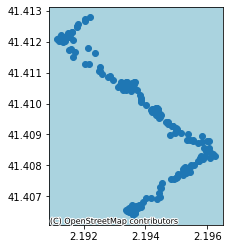

In [135]:
fig, ax = plt.subplots(1, 1)

ax_raw = gdf_raw.plot(ax=ax)
ctx.add_basemap(ax, crs=gdf_raw.crs, source=ctx.providers.OpenStreetMap.Mapnik, zoom=10)


Now that we have the positions, we can proceed to use the MapBox API to perform the map-matching

In [150]:
segments = []

for chunk in chunks(df, MAPBOX_MAX_N_POINTS):

  points = zip(chunk['longitude(deg)'],chunk['latitude(deg)'])
  track_for_mapbox_api = ';'.join([f'{p[0]},{p[1]}' for p in points])

  url = f'https://api.mapbox.com/matching/v5/mapbox/driving/{track_for_mapbox_api}?access_token={MAPBOX_ACCESS_TOKEN}'
  r = requests.get(url)
  js = r.json() 

  segment_points = [shapely.geometry.Point(pt['location'][0], pt['location'][1]) for pt in js['tracepoints'] if pt]

  segments.append(segment_points)

points = []

for segment in segments:
  points += segment

geometry = shapely.geometry.MultiPoint(points)

At this point we already have the map-matched positions and we can proceed to plot it and check the results

In [154]:
gdf_snap = gpd.GeoSeries(geometry)

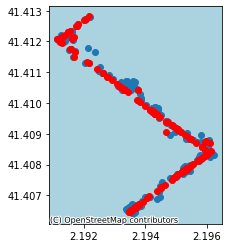

In [155]:
fig, ax = plt.subplots(1, 1)
ax_raw = gdf_raw.plot(ax=ax)
ax_snap = gdf_snap.plot(color='red', ax=ax)
ctx.add_basemap(ax, crs=gdf_raw.crs, source=ctx.providers.OpenStreetMap.Mapnik, zoom=10)
